# Forecasting Example

In this notebook, we have developed code the show an example of how to obtain and plot both mean and interval forecast of a fitted UnnobservedComponentGAS model.

## Import packages

In [ ]:
import Pkg
Pkg.add(url = "https://github.com/LAMPSPUC/UnobservedComponentsGAS.git")

using UnobservedComponentsGAS, Plots, CSV, DataFrames, Metrics

## Reading Energy Consumption data

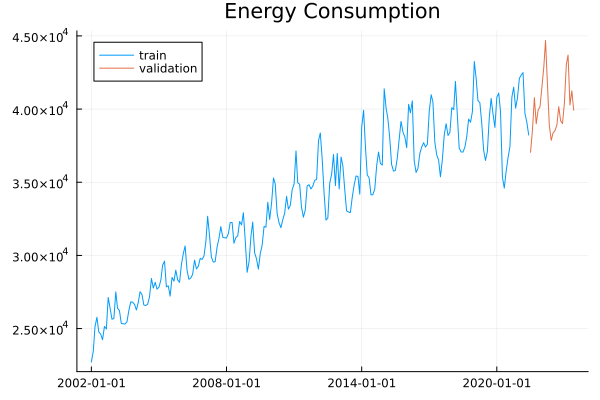

In [23]:
data = CSV.read("data/energy_consumption.csv", DataFrame)

steps_ahead = 24
y_train     = data[1:end-steps_ahead, 2]
y_val       = data[end-steps_ahead+1:end, 2] 
dates_train = data[1:end-steps_ahead, 1]
dates_val   = data[end-steps_ahead+1:end, 1]

plot(title = "Energy Consumption")
plot!(dates_train, y_train, label = "train")
plot!(dates_val, y_val, label = "validation")

## Define a Score-Driven Model

Model specifications:
 - Distribution: LogNormal
 - Only the first parameter as time varying
 - d = 1
 - 500 scenarios to obtain the forecast
 - level component: random walk with slope process
 - seasonality component: deterministic with 12 seasonal periods (monthly seasonality)
 - ar component: missing

Since we have only the first parameter as time varying, we can pass a string "dynamic" instead of a vector of strings ["dynamic", ""].
 - *Example*: we are able to define level = "random walk slope" instead of level = ["random walk slope", ""]


In [24]:
dist                    = UnobservedComponentsGAS.LogNormalDistribution()
time_varying_parameters = [true, false]
d                       = 1.0
num_scenarious          = 500

level       = "random walk slope"
seasonality = "deterministic 12"
ar          = missing

model = UnobservedComponentsGAS.GASModel(dist, time_varying_parameters, d, level,seasonality, ar);

## Fit and Forecast the specified model

In [25]:
fitted_model = UnobservedComponentsGAS.fit(model, y_train; robust = false);
forec        = UnobservedComponentsGAS.predict(model, fitted_model, y_train, steps_ahead, num_scenarious);

┌ Info: Creating GAS model...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:41
┌ Info: Including parameters...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:49
┌ Info: Computing score...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:52
┌ Info: Including components...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:55
┌ Info: Computing initial values...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:58
┌ Info: Including dynamics..
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:64
┌ Info: Including objective funcion...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComp

### The forec object

The *forec* object, returned by the function *forecast()* is a disctionary with 3 keys:
 - mean: keeps a vector the represents the mean forecast
 - scenarios: keeps a matrix that represent all scenarios forecasted
 - intervals: a disctionary the keeps vector for 4 intervals (80% em 95% confidence intervals, both with upper and lower)

## Plot Mean Forecast with Confidence Intervals

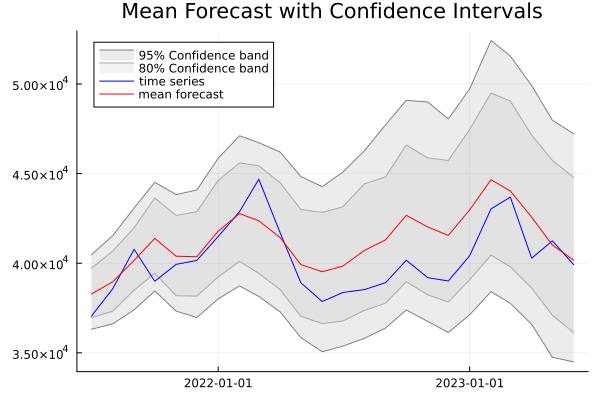

In [26]:
plot(title = "Mean Forecast with Confidence Intervals")
plot!(dates_val, forec["intervals"]["95"]["lower"], fillrange = forec["intervals"]["95"]["upper"], fillalpha = 0.15, color = :grey, label = "95% Confidence band")
plot!(dates_val, forec["intervals"]["80"]["lower"], fillrange = forec["intervals"]["80"]["upper"], fillalpha = 0.15, color = :darkgrey, label = "80% Confidence band")
plot!(dates_val, forec["intervals"]["95"]["upper"], label = "", color = :grey)
plot!(dates_val, forec["intervals"]["80"]["upper"], label = "", color = :darkgrey)
plot!(dates_val, y_val, label = "time series", color = :blue)
plot!(dates_val, forec["mean"], label = "mean forecast", color = :red)

## Plot Mean Forecast with Scenarios

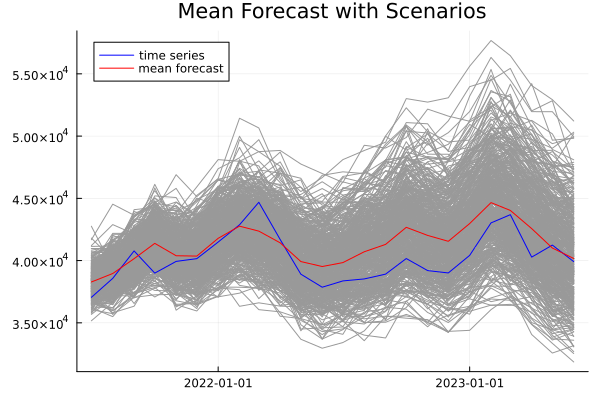

In [27]:
plot(title = "Mean Forecast with Scenarios")
plot!(dates_val, forec["scenarios"], label = "", color = :grey60)
plot!(dates_val, y_val, label = "time series", color = :blue)
plot!(dates_val, forec["mean"], label = "mean forecast", color = :red)

## Accuracy Metrics

There are inumerous useful metrics to quantify the forecast accurary, namely MSE, RMSE, MAPE, MAE. We chose to ilustrate this example with the MSE metric, from the Metrics.jl package.

In [31]:
mse_val = Metrics.mse(forec["mean"], y_val)
println("Validation MSE = ", round(mse_val, digits = 3))

Validation MSE = 2.725005992e6
